<a href="https://colab.research.google.com/github/oraziotorre/TTinsight/blob/main/TTinsight_ModelDevelopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTinsight


---


## Model Development


### Inizializzazione

In [1]:
# Gestione dei dati
import pandas as pd
import numpy as np
from collections import Counter
import ast
import os
import math
import shutil
import joblib
from scipy.special import comb
from collections import defaultdict
from sklearn.utils import shuffle

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

# Machine Learning e metriche
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    log_loss,
    f1_score,
)

# Deep Learning con Keras e TensorFlow
import tensorflow as tf
from sklearn.svm import SVC
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    Concatenate,
    Masking,
    Embedding,
    Dropout,
    concatenate,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences

# Scaler fixed for non binary values
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib
from xgboost import XGBClassifier

In [2]:
dataset = pd.read_csv("cleaned_dataset.csv")

dataset

,is_final,final_set,opponent_final_set,player_points,set_result,last_comeback,points_diff,points_length
0,1,0,0,"[0, 0, 1, 1, 0, 1, 1]",0,2,1,7
1,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0]",0,-1,0,8
2,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0]",0,-2,-1,9
3,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1]",0,1,0,10
4,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1]",0,2,1,11
...,...,...,...,...,...,...,...,...
489295,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0]",0,-5,-3,9
489296,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]",0,1,-3,11
489297,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]",0,2,-2,12
489298,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]",0,-1,-3,13


## Funzioni training split

Funzione che procede alla eliminazione dei folder quando è necessario

Suddivisione del dataset iniziale in numerosi dataset sulla base delle istanze dei punteggi

In [3]:
# Funzione per calcolare la combinazione di punteggi
def extract_scores(player_points):
    # Se player_points è una stringa, la converte in una lista
    if isinstance(player_points, str):
        player_points = ast.literal_eval(player_points)

    # Conta i punteggi di 1 e 0
    count_ones = player_points.count(1)
    count_zeros = player_points.count(0)

    return f"{count_ones}-{count_zeros}"

# Funzione per creare i dataset separati in base alla combinazione di punteggi
def create_datasets_by_score_combinations(df):
    # Applica la funzione `extract_scores` per ottenere le combinazioni di punteggi
    score_combinations = df['player_points'].apply(extract_scores)

    # Inizializza un dizionario per memorizzare i dataset
    datasets = defaultdict(list)

    # Raggruppa le righe in base alla combinazione di punteggi
    for index, row in df.iterrows():
        score_combination = score_combinations[index]
        datasets[score_combination].append(row)

    # Crea un dataframe per ogni combinazione di punteggi
    result_datasets = {}
    for score_combination, rows in datasets.items():
        result_datasets[score_combination] = pd.DataFrame(rows)

    return result_datasets

# Funzione per salvare i dataset in una cartella
def save_datasets_to_folder(datasets, folder_path):
    # Crea la cartella se non esiste
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Salva ogni dataset in un file CSV
    for score_combination, dataset in datasets.items():
        # Conta il numero di righe nel dataset
        num_rows = len(dataset)

        # Usa "dataset_" come prefisso e la combinazione di punteggi come parte del nome
        filename = f"{score_combination}.csv"
        filepath = os.path.join(folder_path, filename)

        # Salva il dataset nel file CSV
        dataset.to_csv(filepath, index=False)

        # Stampa il numero di righe per ciascun dataset
        print(f"Dataset per la combinazione {score_combination} salvato in {filepath} con {num_rows} righe.")

# Esegui la funzione sul dataset
result_datasets = create_datasets_by_score_combinations(dataset)

# Specifica la cartella dove salvare i file
folder_path = '/content/datasets'

# Salva i dataset separati nella cartella
save_datasets_to_folder(result_datasets, folder_path)



Dataset per la combinazione 4-3 salvato in /content/datasets/4-3.csv con 18156 righe.
Dataset per la combinazione 4-4 salvato in /content/datasets/4-4.csv con 17646 righe.
Dataset per la combinazione 4-5 salvato in /content/datasets/4-5.csv con 16032 righe.
Dataset per la combinazione 5-5 salvato in /content/datasets/5-5.csv con 15734 righe.
Dataset per la combinazione 6-5 salvato in /content/datasets/6-5.csv con 14481 righe.
Dataset per la combinazione 6-6 salvato in /content/datasets/6-6.csv con 14256 righe.
Dataset per la combinazione 6-7 salvato in /content/datasets/6-7.csv con 13102 righe.
Dataset per la combinazione 6-8 salvato in /content/datasets/6-8.csv con 11496 righe.
Dataset per la combinazione 6-9 salvato in /content/datasets/6-9.csv con 9946 righe.
Dataset per la combinazione 7-9 salvato in /content/datasets/7-9.csv con 10867 righe.
Dataset per la combinazione 5-3 salvato in /content/datasets/5-3.csv con 14858 righe.
Dataset per la combinazione 6-3 salvato in /content/dat

Verifica dei numeri

In [4]:

def extract_scores(player_points):
    # Se player_points è una stringa, la converte in una lista
    if isinstance(player_points, str):
        player_points = ast.literal_eval(player_points)

    # Conta i punteggi di 1 e 0
    count_ones = player_points.count(1)
    count_zeros = player_points.count(0)

    return f"{count_ones}-{count_zeros}"
# Funzione principale che calcola e ritorna le combinazioni di punteggio
def count_score_combinations(dataframe):
    # Calcola le combinazioni senza aggiungerle al dataframe
    score_combinations = dataframe['player_points'].apply(extract_scores)

    # Conta le occorrenze di ciascuna combinazione
    return score_combinations.value_counts()

# Calcolo e stampa delle combinazioni
score_count = count_score_combinations(dataset)
print(score_count)

player_points
4-3    18156
3-4    17960
4-4    17646
4-5    16032
5-4    15932
5-5    15734
5-3    14858
3-5    14741
6-5    14481
5-6    14262
6-6    14256
6-4    13625
4-6    13457
7-6    13280
6-7    13102
7-7    13051
7-5    12586
5-7    12381
8-7    12170
7-8    12062
8-6    11810
8-8    11792
5-2    11702
2-5    11541
6-3    11500
6-8    11496
3-6    11282
9-8    11251
7-4    11143
8-9    11093
9-7    11038
4-7    11022
9-9    10952
7-9    10867
8-5    10599
5-8    10406
9-6    10088
6-9     9946
Name: count, dtype: int64


In [5]:
# Funzione per fare il train-test split sui file CSV
def split_train_test_for_csv_files(input_folder, output_folder, test_size=0.2, random_state=42):
    # Verifica se la cartella di output esiste, altrimenti la crea
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Ottieni tutti i file CSV dalla cartella di input
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".csv"):
            # Costruisci il percorso completo del file CSV
            file_path = os.path.join(input_folder, file_name)

            # Leggi il file CSV in un DataFrame
            df = pd.read_csv(file_path)

            # Suddividi il dataset in training e test (80/20)
            train_data, test_data = train_test_split(df, test_size=test_size, random_state=random_state)

            # Crea i nomi dei file per il training e il test
            train_filename = file_name.replace(".csv", "_train.csv")
            test_filename = file_name.replace(".csv", "_test.csv")

            # Costruisci i percorsi per i file di training e test
            train_filepath = os.path.join(output_folder, train_filename)
            test_filepath = os.path.join(output_folder, test_filename)

            # Salva i dati di training e test in nuovi file CSV
            train_data.to_csv(train_filepath, index=False)
            test_data.to_csv(test_filepath, index=False)

            # Stampa il risultato
            print(f"File '{file_name}' diviso in {train_filename} e {test_filename}.")
            print(f"  - {len(train_data)} righe per il training.")
            print(f"  - {len(test_data)} righe per il test.")

# Esegui la funzione per suddividere i dataset
input_folder = '/content/datasets'  # Cartella dove sono i file CSV originali
output_folder = '/content/split_datasets'  # Cartella dove salvare i file divisi

split_train_test_for_csv_files(input_folder, output_folder)


File '6-4.csv' diviso in 6-4_train.csv e 6-4_test.csv.
  - 10900 righe per il training.
  - 2725 righe per il test.
File '7-5.csv' diviso in 7-5_train.csv e 7-5_test.csv.
  - 10068 righe per il training.
  - 2518 righe per il test.
File '8-7.csv' diviso in 8-7_train.csv e 8-7_test.csv.
  - 9736 righe per il training.
  - 2434 righe per il test.
File '6-5.csv' diviso in 6-5_train.csv e 6-5_test.csv.
  - 11584 righe per il training.
  - 2897 righe per il test.
File '5-6.csv' diviso in 5-6_train.csv e 5-6_test.csv.
  - 11409 righe per il training.
  - 2853 righe per il test.
File '7-9.csv' diviso in 7-9_train.csv e 7-9_test.csv.
  - 8693 righe per il training.
  - 2174 righe per il test.
File '4-4.csv' diviso in 4-4_train.csv e 4-4_test.csv.
  - 14116 righe per il training.
  - 3530 righe per il test.
File '5-2.csv' diviso in 5-2_train.csv e 5-2_test.csv.
  - 9361 righe per il training.
  - 2341 righe per il test.
File '5-5.csv' diviso in 5-5_train.csv e 5-5_test.csv.
  - 12587 righe per 

In [6]:
# Funzione per creare il dataset "opposite" (opponent) modificato
def create_opponent_dataset(df):
    # Copia del dataframe originale per non modificarlo direttamente
    opponent_df = df.copy()

    # 1. Scambia 'final_set' e 'opponent_final_set'
    opponent_df['final_set'], opponent_df['opponent_final_set'] = opponent_df['opponent_final_set'], opponent_df['final_set']

    # 2. Scambia i valori in 'player_points'
    opponent_df['player_points'] = opponent_df['player_points'].apply(lambda points: [1 - p for p in ast.literal_eval(points)])

    # 3. Scambia 'set_result' (0 diventa 1 e viceversa)
    opponent_df['set_result'] = opponent_df['set_result'].apply(lambda x: 1 - x)

    # 4. Inverti 'last_come_back' e 'point_diff' (positivi diventano negativi e viceversa)
    opponent_df['last_comeback'] = opponent_df['last_comeback'].apply(lambda x: -x)
    opponent_df['points_diff'] = opponent_df['points_diff'].apply(lambda x: -x)

    return opponent_df

# Funzione per caricare e modificare i dataset separati in training e test
def create_opponent_datasets(input_folder, output_folder):
    # Verifica se la cartella di output esiste, altrimenti la crea
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Ottieni tutti i file CSV dalla cartella di input
    for file_name in os.listdir(input_folder):
        if file_name.endswith("_train.csv") or file_name.endswith("_test.csv"):
            # Costruisci il percorso completo del file CSV
            file_path = os.path.join(input_folder, file_name)

            # Leggi il file CSV in un DataFrame
            df = pd.read_csv(file_path)

            # Crea il dataset "opponent"
            opponent_df = create_opponent_dataset(df)

            # Estrai il punteggio dal nome del file (ad esempio '5-3_train.csv' -> '5-3')
            base_name = file_name.split('_')[0]  # '5-3' da '5-3_train.csv'

            # Inverti i numeri (ad esempio '5-3' -> '3-5')
            inverted_score = '-'.join(base_name.split('-')[::-1])  # '5-3' -> '3-5'

            # Crea il nuovo nome del file aggiungendo '_opp'
            opponent_filename = f"{inverted_score}_train_opp.csv" if "_train" in file_name else f"{inverted_score}_test_opp.csv"

            # Percorso completo del nuovo file
            opponent_filepath = os.path.join(output_folder, opponent_filename)

            # Salva il nuovo dataset "opponent"
            opponent_df.to_csv(opponent_filepath, index=False)

            # Stampa il risultato
            print(f"File '{file_name}' trasformato in '{opponent_filename}'.")

# Esegui la funzione per creare i dataset "opponent"
input_folder = '/content/split_datasets'  # Cartella con i file CSV separati per training e test
output_folder = '/content/opponent_datasets'  # Cartella dove salvare i file trasformati

create_opponent_datasets(input_folder, output_folder)



File '9-6_train.csv' trasformato in '6-9_train_opp.csv'.
File '6-5_test.csv' trasformato in '5-6_test_opp.csv'.
File '7-6_train.csv' trasformato in '6-7_train_opp.csv'.
File '4-4_test.csv' trasformato in '4-4_test_opp.csv'.
File '7-5_test.csv' trasformato in '5-7_test_opp.csv'.
File '5-7_train.csv' trasformato in '7-5_train_opp.csv'.
File '5-4_train.csv' trasformato in '4-5_train_opp.csv'.
File '6-4_train.csv' trasformato in '4-6_train_opp.csv'.
File '9-9_train.csv' trasformato in '9-9_train_opp.csv'.
File '5-5_test.csv' trasformato in '5-5_test_opp.csv'.
File '6-4_test.csv' trasformato in '4-6_test_opp.csv'.
File '5-4_test.csv' trasformato in '4-5_test_opp.csv'.
File '9-9_test.csv' trasformato in '9-9_test_opp.csv'.
File '6-3_test.csv' trasformato in '3-6_test_opp.csv'.
File '6-6_test.csv' trasformato in '6-6_test_opp.csv'.
File '4-7_test.csv' trasformato in '7-4_test_opp.csv'.
File '4-5_train.csv' trasformato in '5-4_train_opp.csv'.
File '7-8_test.csv' trasformato in '8-7_test_opp.cs

In [7]:

# Funzione per unire i dataset originali con quelli "opponent"
def merge_datasets(original_folder, opponent_folder, output_folder):
    # Verifica se la cartella di output esiste, altrimenti la crea
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Ottieni tutti i file CSV dalla cartella degli originali (train e test)
    original_train_files = {f.replace("_train.csv", ""): f for f in os.listdir(original_folder) if f.endswith("_train.csv")}
    opponent_train_files = {f.replace("_train_opp.csv", ""): f for f in os.listdir(opponent_folder) if f.endswith("_train_opp.csv")}

    original_test_files = {f.replace("_test.csv", ""): f for f in os.listdir(original_folder) if f.endswith("_test.csv")}
    opponent_test_files = {f.replace("_test_opp.csv", ""): f for f in os.listdir(opponent_folder) if f.endswith("_test_opp.csv")}

    # Unisci i file per il training
    for base_name, original_file in original_train_files.items():
        opponent_file = opponent_train_files.get(base_name)

        if opponent_file:
            original_path = os.path.join(original_folder, original_file)
            opponent_path = os.path.join(opponent_folder, opponent_file)

            # Leggi i file CSV in DataFrame
            original_df = pd.read_csv(original_path)
            opponent_df = pd.read_csv(opponent_path)

            # Unisci i due DataFrame
            merged_train_df = pd.concat([original_df, opponent_df], ignore_index=True)

            # Salva il nuovo dataset unito
            merged_train_filename = f"merged_{original_file}"
            merged_train_filepath = os.path.join(output_folder, merged_train_filename)
            merged_train_df.to_csv(merged_train_filepath, index=False)

            # Stampa il risultato
            print(f"Unito '{original_file}' e '{opponent_file}' in '{merged_train_filename}'.")

    # Unisci i file per il test
    for base_name, original_file in original_test_files.items():
        opponent_file = opponent_test_files.get(base_name)

        if opponent_file:
            original_path = os.path.join(original_folder, original_file)
            opponent_path = os.path.join(opponent_folder, opponent_file)

            # Leggi i file CSV in DataFrame
            original_df = pd.read_csv(original_path)
            opponent_df = pd.read_csv(opponent_path)

            # Unisci i due DataFrame
            merged_test_df = pd.concat([original_df, opponent_df], ignore_index=True)

            # Salva il nuovo dataset unito
            merged_test_filename = f"merged_{original_file}"
            merged_test_filepath = os.path.join(output_folder, merged_test_filename)
            merged_test_df.to_csv(merged_test_filepath, index=False)

            # Stampa il risultato
            print(f"Unito '{original_file}' e '{opponent_file}' in '{merged_test_filename}'.")

# Esegui la funzione per unire i dataset
original_folder = '/content/split_datasets'  # Cartella con i file originali (train e test)
opponent_folder = '/content/opponent_datasets'  # Cartella con i file degli opponent (train_opp e test_opp)
output_folder = '/content/merged_datasets'  # Cartella dove salvare i file uniti

merge_datasets(original_folder, opponent_folder, output_folder)


Unito '9-6_train.csv' e '9-6_train_opp.csv' in 'merged_9-6_train.csv'.
Unito '7-6_train.csv' e '7-6_train_opp.csv' in 'merged_7-6_train.csv'.
Unito '5-7_train.csv' e '5-7_train_opp.csv' in 'merged_5-7_train.csv'.
Unito '5-4_train.csv' e '5-4_train_opp.csv' in 'merged_5-4_train.csv'.
Unito '6-4_train.csv' e '6-4_train_opp.csv' in 'merged_6-4_train.csv'.
Unito '9-9_train.csv' e '9-9_train_opp.csv' in 'merged_9-9_train.csv'.
Unito '4-5_train.csv' e '4-5_train_opp.csv' in 'merged_4-5_train.csv'.
Unito '6-3_train.csv' e '6-3_train_opp.csv' in 'merged_6-3_train.csv'.
Unito '5-6_train.csv' e '5-6_train_opp.csv' in 'merged_5-6_train.csv'.
Unito '5-3_train.csv' e '5-3_train_opp.csv' in 'merged_5-3_train.csv'.
Unito '8-5_train.csv' e '8-5_train_opp.csv' in 'merged_8-5_train.csv'.
Unito '4-4_train.csv' e '4-4_train_opp.csv' in 'merged_4-4_train.csv'.
Unito '3-5_train.csv' e '3-5_train_opp.csv' in 'merged_3-5_train.csv'.
Unito '7-9_train.csv' e '7-9_train_opp.csv' in 'merged_7-9_train.csv'.
Unito 

In [8]:
import glob

# Specifica il percorso della cartella contenente i dataset
folder_path = 'merged_datasets'

# Usa glob per raccogliere tutti i file che terminano con '_train.csv'
file_pattern = os.path.join(folder_path, '*_train.csv')
all_files = glob.glob(file_pattern)

# Inizializza una lista per memorizzare i dataframe
dfs = []

# Leggi e aggiungi ogni file CSV alla lista
for file in all_files:
    df = pd.read_csv(file)  # Carica il dataset
    dfs.append(df)  # Aggiungi il dataframe alla lista

# Unisci tutti i dataframe in un unico grande dataframe
merged_df = pd.concat(dfs, ignore_index=True)

# Salva il dataframe unito in un nuovo file CSV
merged_df.to_csv('training_set.csv', index=False)

print('Datasets merged successfully!')

Datasets merged successfully!


In [9]:
# Specifica il percorso del file
folder_path = '/content/merged_datasets'
file_name = 'merged_6-4_train.csv'
file_path = os.path.join(folder_path, file_name)

# Verifica se il file esiste
if os.path.exists(file_path):
    # Leggi il dataset con Pandas
    df = pd.read_csv(file_path)

    # Converte la colonna 'player_points' in una lista di numeri (se non lo è già)
    def clean_player_points(value):
        if isinstance(value, str):
            # Interpreta la stringa come una lista
            return ast.literal_eval(value)
        return value  # Se è già una lista, restituisci com'è

    df['player_points'] = df['player_points'].apply(clean_player_points)

    # Dizionario per tracciare le istanze uniche
    instance_stats = {}

    # Itera sulle righe del DataFrame
    for _, row in df.iterrows():
        # Converti 'player_points' in una tupla per renderla hashabile
        player_points = tuple(row['player_points'])  # Converti in tupla
        set_result = row['set_result']  # Valore di 'set_result'

        # Se l'istanza non è ancora nel dizionario, inizializzala
        if player_points not in instance_stats:
            instance_stats[player_points] = {'tot': 0, 'win': 0}

        # Aggiorna il conteggio totale
        instance_stats[player_points]['tot'] += 1

        # Aggiorna il conteggio delle vittorie se 'set_result' è 1
        if set_result == 1:
            instance_stats[player_points]['win'] += 1

    # Creazione di un DataFrame per visualizzare i risultati
    result_data = [
        {
            'player_points': str(list(points)),  # Converti la tupla in lista e poi in stringa
            'tot': stats['tot'],
            'win': stats['win'],
            'win/tot': stats['win'] / stats['tot']  # Calcola la probabilità di vittoria
        }
        for points, stats in instance_stats.items()
    ]
    result_df = pd.DataFrame(result_data)

    # Ordina il DataFrame in base alla colonna 'win/tot' (probabilità di vittoria)
    result_df = result_df.sort_values(by='win/tot', ascending=True)  # ordina dal più basso al più alto

    # Configura Pandas per mostrare tutte le colonne e disabilitare la troncatura
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', None)  # Mostra tutto il contenuto delle celle

    # Stampa i risultati
    print("Risultati delle istanze uniche con totali, vittorie e probabilità di vittoria (ordinati per probabilità crescente):")
    print(result_df)
else:
    print(f"File non trovato: {file_path}")

Risultati delle istanze uniche con totali, vittorie e probabilità di vittoria (ordinati per probabilità crescente):
                      player_points  tot  win   win/tot
102  [0, 1, 1, 0, 0, 1, 1, 0, 1, 1]   81   50  0.617284
51   [1, 0, 0, 0, 1, 1, 1, 1, 0, 1]  114   72  0.631579
177  [0, 1, 0, 0, 0, 1, 1, 1, 1, 1]   80   52  0.650000
88   [1, 1, 1, 0, 1, 0, 1, 0, 1, 0]  110   72  0.654545
78   [1, 0, 0, 0, 0, 1, 1, 1, 1, 1]   97   64  0.659794
8    [0, 1, 1, 1, 1, 0, 0, 1, 1, 0]  124   82  0.661290
77   [1, 1, 0, 1, 0, 1, 0, 1, 0, 1]   95   63  0.663158
91   [1, 0, 1, 1, 1, 1, 0, 0, 1, 0]  110   73  0.663636
55   [0, 0, 1, 1, 1, 0, 1, 1, 1, 0]  111   74  0.666667
144  [1, 1, 0, 0, 1, 1, 0, 1, 1, 0]  121   81  0.669421
99   [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]  100   67  0.670000
173  [0, 0, 1, 1, 1, 1, 1, 0, 1, 0]   94   63  0.670213
160  [1, 1, 0, 1, 1, 0, 1, 0, 0, 1]   91   61  0.670330
45   [0, 1, 0, 1, 1, 1, 0, 1, 0, 1]  101   68  0.673267
171  [0, 0, 1, 0, 1, 1, 1, 1, 0, 1]  103   7

In [10]:
import os
import shutil

def sposta_e_rinomina_file():
    # Nome della cartella originale e della nuova cartella
    cartella_originale = "merged_datasets"
    cartella_test = "dataset_test"

    # Crea la cartella "dataset_test" se non esiste
    if not os.path.exists(cartella_test):
        os.makedirs(cartella_test)

    # Itera su tutti i file nella cartella originale
    for file_name in os.listdir(cartella_originale):
        # Controlla se il file è un "test"
        if "test" in file_name:
            # Nuovo nome del file senza il prefisso "merged_"
            nuovo_nome = file_name.replace("merged_", "")
            # Percorso completo del file originale e del file spostato
            percorso_originale = os.path.join(cartella_originale, file_name)
            percorso_nuovo = os.path.join(cartella_test, nuovo_nome)
            # Sposta e rinomina il file
            shutil.move(percorso_originale, percorso_nuovo)


# Esegui la funzione
sposta_e_rinomina_file()

In [11]:
import os
import shutil

def sposta_e_rinomina_file():
    # Nome della cartella originale e della nuova cartella
    cartella_originale = "merged_datasets"
    cartella_test = "dataset_train"

    # Crea la cartella "dataset_train" se non esiste
    if not os.path.exists(cartella_test):
        os.makedirs(cartella_test)

    # Itera su tutti i file nella cartella originale
    for file_name in os.listdir(cartella_originale):
        # Controlla se il file è un "test"
        if "train" in file_name:
            # Nuovo nome del file senza il prefisso "merged_"
            nuovo_nome = file_name.replace("merged_", "")
            # Percorso completo del file originale e del file spostato
            percorso_originale = os.path.join(cartella_originale, file_name)
            percorso_nuovo = os.path.join(cartella_test, nuovo_nome)
            # Sposta e rinomina il file
            shutil.move(percorso_originale, percorso_nuovo)


# Esegui la funzione
sposta_e_rinomina_file()

In [12]:
# 1. Funzione per caricare e combinare tutti i file .csv in un unico DataFrame
def load_and_combine_files(file_paths):
    test_data = []
    for file in file_paths:
        df = pd.read_csv(file)
        test_data.append(df)
    return pd.concat(test_data, ignore_index=True)

# 2. Ottieni i percorsi di tutti i file .csv nella cartella 'dataset_test'
test_files = [os.path.join('dataset_test', f) for f in os.listdir('dataset_test') if f.endswith('.csv')]

# 3. Carica e combina tutti i file in un unico DataFrame
combined_test_data = load_and_combine_files(test_files)

# 4. Salva il DataFrame combinato in un nuovo file CSV
combined_test_data.to_csv('test_set.csv', index=False)

print("File combinato salvato come 'test_set.csv'")

File combinato salvato come 'test_set.csv'


In [19]:
def calculate_difference(filename):
    # Estrae i numeri dal nome del file, ad esempio "9-9_train.csv"
    parts = filename.split('_')[0].split('-')
    num1 = int(parts[0])
    num2 = int(parts[1])

    # Calcola la differenza assoluta
    return abs(num1 - num2)

def merge_and_save_datasets_by_difference(dataset_train_path, dataset_test_path, output_train_folder, output_test_folder):
    # Crea dizionari per accumulare i DataFrame per ogni differenza
    train_diff_dfs = {i: [] for i in range(4)}  # Differenze da 0 a 3
    test_diff_dfs = {i: [] for i in range(4)}

    # Leggi tutti i file da dataset_train
    train_files = [f for f in os.listdir(dataset_train_path) if f.endswith('.csv')]

    # Unisci i dataset in base alla differenza per il training set
    for file in train_files:
        diff = calculate_difference(file)  # Calcola la differenza assoluta
        if diff <= 3:  # Considera solo differenze da 0 a 3
            df = pd.read_csv(os.path.join(dataset_train_path, file))  # Carica il dataset
            train_diff_dfs[diff].append(df)  # Aggiungi il DataFrame alla lista corrispondente

    # Leggi tutti i file da dataset_test
    test_files = [f for f in os.listdir(dataset_test_path) if f.endswith('.csv')]

    # Unisci i dataset in base alla differenza per il test set
    for file in test_files:
        diff = calculate_difference(file)  # Calcola la differenza assoluta
        if diff <= 3:  # Considera solo differenze da 0 a 3
            df = pd.read_csv(os.path.join(dataset_test_path, file))  # Carica il dataset
            test_diff_dfs[diff].append(df)  # Aggiungi il DataFrame alla lista corrispondente

    # Crea le cartelle di destinazione per i nuovi dataset uniti
    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_test_folder, exist_ok=True)

    # Salva i DataFrame uniti per ogni differenza nei rispettivi file CSV
    for diff in range(4):
        if train_diff_dfs[diff]:
            # Unisci tutti i DataFrame della stessa differenza
            train_merged = pd.concat(train_diff_dfs[diff], ignore_index=True)
            train_merged.to_csv(os.path.join(output_train_folder, f"dataset_train_diff_{diff}.csv"), index=False)

        if test_diff_dfs[diff]:
            # Unisci tutti i DataFrame della stessa differenza
            test_merged = pd.concat(test_diff_dfs[diff], ignore_index=True)
            test_merged.to_csv(os.path.join(output_test_folder, f"dataset_test_diff_{diff}.csv"), index=False)

# Percorsi delle cartelle
dataset_train_path = '/content/dataset_train'
dataset_test_path = '/content/dataset_test'

# Cartelle di destinazione per i nuovi dataset uniti
output_train_folder = '/content/merged_train'
output_test_folder = '/content/merged_test'

# Unisci e salva i dataset
merge_and_save_datasets_by_difference(dataset_train_path, dataset_test_path, output_train_folder, output_test_folder)

print("Unione e salvataggio dei dataset completati con successo.")


Unione e salvataggio dei dataset completati con successo.


In [18]:
# Funzione per eliminare cartelle specificate
def delete_folders(folders):
    for folder in folders:
        if os.path.exists(folder):
            try:
                shutil.rmtree(folder)  # Rimuove la cartella e tutto il suo contenuto
                print(f"La cartella '{folder}' è stata eliminata.")
            except Exception as e:
                print(f"Errore durante l'eliminazione della cartella '{folder}': {e}")
        else:
            print(f"La cartella '{folder}' non esiste.")

# Lista delle cartelle da eliminare
folders_to_delete = ['/content/datasets', '/content/split_datasets', '/content/opponent_datasets','/content/merged_datasets','/content/merged_test','/content/merged_train']

# Esegui la funzione per eliminare le cartelle
delete_folders(folders_to_delete)


La cartella '/content/datasets' non esiste.
La cartella '/content/split_datasets' non esiste.
La cartella '/content/opponent_datasets' non esiste.
La cartella '/content/merged_datasets' non esiste.
La cartella '/content/merged_test' è stata eliminata.
La cartella '/content/merged_train' è stata eliminata.


# Training modelli

In [ ]:
training_set = pd.read_csv("training_set.csv")
training_set = training_set.sample(frac=1, random_state=42).reset_index(drop=True)

test_set = pd.read_csv("test_set.csv")
test_set = test_set.sample(frac=1, random_state=42).reset_index(drop=True)

dataset = pd.concat([training_set, test_set], ignore_index=True)
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
columns = ['is_final', 'final_set', 'opponent_final_set','last_comeback', 'points_diff', 'points_length']

X_train = training_set[columns].values

Y_train = training_set['set_result'].values

X_test =  test_set[columns].values

Y_test = test_set['set_result'].values

In [ ]:
# Prepara i dati (scaling)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train_scaled, Y_train)

LogisticRegression(max_iter=1000, random_state=42)

### XGboost Random Forest

In [ ]:
# Crea il modello XGBoost
xgboost = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss')
#####Capire se si può migliorare qualcosa negli iperparametri
# Allena il modello
xgboost.fit(X_train_scaled, Y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:46:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### SVM

In [ ]:
# Creiamo il modello LinearSVC
svm_model = LinearSVC(C=1.0, random_state=42)

# Calibrazione del modello usando Platt scaling
calibrated_svm = CalibratedClassifierCV(svm_model, method='sigmoid', cv='prefit')

# Addestriamo il modello
svm_model.fit(X_train_scaled, Y_train)

# Ora calibriamo le probabilità
calibrated_svm.fit(X_train_scaled, Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit', estimator=LinearSVC(random_state=42))

In [ ]:
# 'hinge'        : SVM lineare (Support Vector Machine)
# 'log'          : Regressione logistica (logistic regression)
# 'perceptron'   : Perceptron (rete neurale semplice)
# 'squared_hinge': SVM lineare con perdita quadrata (penalizza maggiormente gli errori)
# 'modified_huber': Combinazione di SVM e logistica con una perdita meno sensibile agli outlier
# Pre-elaborazione: applicare lo scaling ai dati

# Creiamo il modello SGD
sgd_svm = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)

# Addestriamo il modello
sgd_svm.fit(X_train_scaled, Y_train)

SGDClassifier(loss='log_loss', random_state=42)

In [ ]:
###AGGIUNGERE SCALING A QUESTA FUNZIONE

# Funzione per test personalizzato
def testing_personalizzato(cartella_test, modello):
    risultati = []

    # Itera su tutti i file nella cartella
    for file_name in os.listdir(cartella_test):
        if file_name.endswith(".csv"):
            # Carica i dati di test
            percorso_file = os.path.join(cartella_test, file_name)
            dataset_test = pd.read_csv(percorso_file)

            # Preparare X_test e Y_test
            columns = ['is_final', 'final_set', 'opponent_final_set', 'last_comeback', 'points_diff', 'points_length']
            X_test = dataset_test[columns].values
            Y_test = dataset_test['set_result'].values

            if scaler is not None:
                X_test = scaler.transform(X_test)

            # Previsioni
            y_pred = modello.predict(X_test)

            # Calcolare l'accuratezza
            accuracy = accuracy_score(Y_test, y_pred)

            # Salva i risultati per ogni file
            risultati.append({'file': file_name, 'accuracy': accuracy})

            # Stampa i risultati per questo file
            print(f"Accuratezza per {file_name}: {accuracy:.4f}")

    return risultati


# Esegui il testing personalizzato
cartella_test = "dataset_test"

risultati_test = testing_personalizzato(cartella_test, log_reg)

Accuratezza per 6-5_test.csv: 0.6383
Accuratezza per 4-4_test.csv: 0.5459
Accuratezza per 7-5_test.csv: 0.7740
Accuratezza per 5-5_test.csv: 0.5246
Accuratezza per 6-4_test.csv: 0.7521
Accuratezza per 5-4_test.csv: 0.6301
Accuratezza per 9-9_test.csv: 0.5308
Accuratezza per 6-3_test.csv: 0.8394
Accuratezza per 6-6_test.csv: 0.5365
Accuratezza per 4-7_test.csv: 0.8584
Accuratezza per 7-8_test.csv: 0.6718
Accuratezza per 5-3_test.csv: 0.7347
Accuratezza per 4-5_test.csv: 0.6301
Accuratezza per 3-5_test.csv: 0.7347
Accuratezza per 3-6_test.csv: 0.8394
Accuratezza per 6-8_test.csv: 0.7881
Accuratezza per 7-9_test.csv: 0.8252
Accuratezza per 5-8_test.csv: 0.8801
Accuratezza per 7-7_test.csv: 0.5465
Accuratezza per 9-6_test.csv: 0.9152
Accuratezza per 9-7_test.csv: 0.8252
Accuratezza per 6-9_test.csv: 0.9152
Accuratezza per 5-6_test.csv: 0.6383
Accuratezza per 8-8_test.csv: 0.5189
Accuratezza per 2-5_test.csv: 0.8200
Accuratezza per 8-9_test.csv: 0.6955
Accuratezza per 7-4_test.csv: 0.8584
A

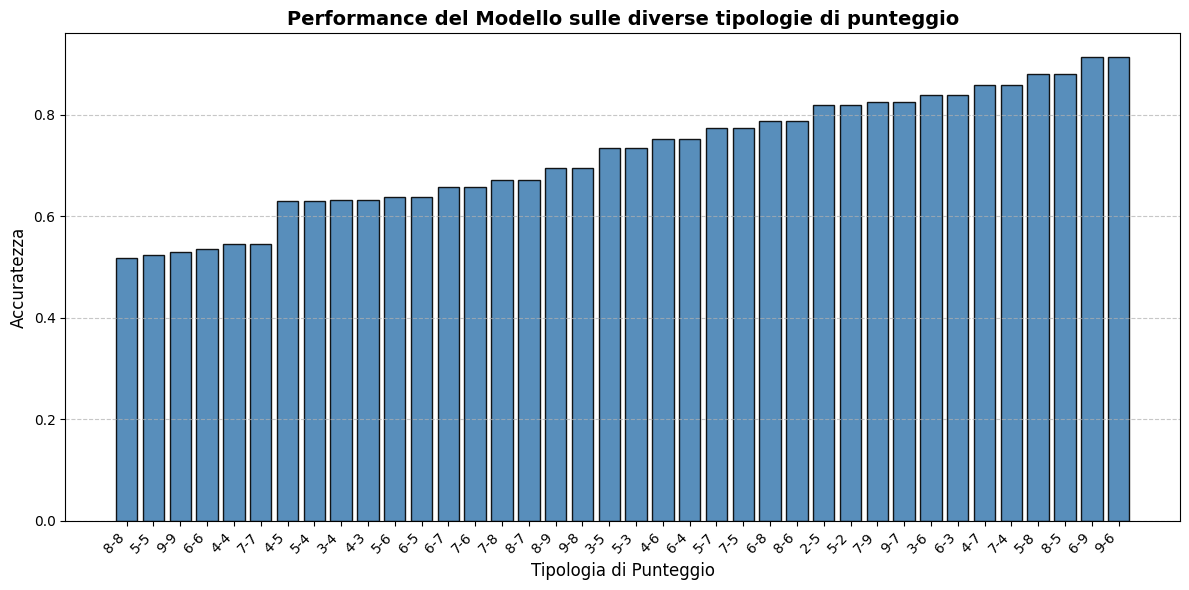

In [ ]:
def grafico_barre_migliorato(risultati):
    # Estrai nomi file e accuratezze
    files = [result['file'][:3] for result in risultati]  # Prendi solo i primi 3 caratteri dei file
    accuracies = [result['accuracy'] for result in risultati]

    # Ordina i risultati in base all'accuratezza
    risultati_ordinati = sorted(zip(accuracies, files))
    accuracies_ordinate, files_ordinati = zip(*risultati_ordinati)

    # Creare il grafico
    plt.figure(figsize=(12, 6))
    plt.bar(files_ordinati, accuracies_ordinate, color='steelblue', edgecolor='black', alpha=0.9)

    # Miglioramenti estetici
    plt.xlabel('Tipologia di Punteggio', fontsize=12)
    plt.ylabel('Accuratezza', fontsize=12)
    plt.title('Performance del Modello sulle diverse tipologie di punteggio', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Usa i risultati del testing
grafico_barre_migliorato(risultati_test)

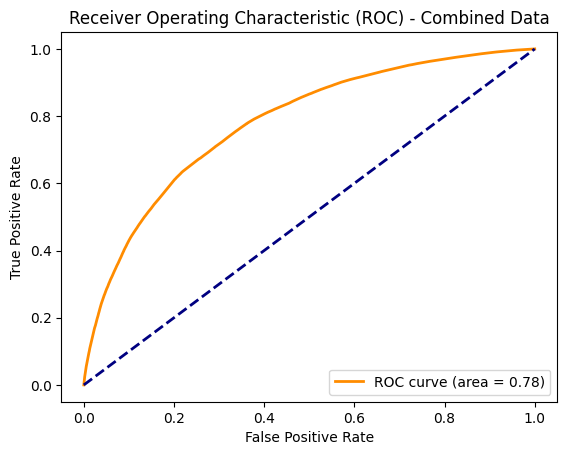

In [ ]:
#### QUI CAMBIARE Modello per vedere la roc curve
#Modelli attuali:  sgd_svm, calibrated_svm, xgboost, log_reg, rf(rf è il peggiore ma perchè è giusto per vedere l'importanza delle feature)
y_prob = xgboost.predict_proba(X_test_scaled)[:, 1]

# 6. Calcola la ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 7. Traccia la ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Combined Data')
plt.legend(loc='lower right')
plt.show()

### Random Forest

In [ ]:
X = np.array((dataset[['is_final', 'final_set', 'opponent_final_set', 'last_comeback', 'points_diff', 'points_length']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

# Crea il modello di Random Forest
rf = RandomForestClassifier(random_state=42)

# Variabili per raccogliere i risultati
feature_importances = []

# Divisione train-test (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

rf.fit(X_train, Y_train)

# Nomi delle feature
feature_names = ['is_final', 'final_set', 'opponent_final_set', 'last_comeback', 'points_diff', 'points_length']


# Estrai le feature importance per ogni albero
tree_importances = np.array([tree.feature_importances_ for tree in rf.estimators_])

# Calcola la media e la deviazione standard per ogni feature
mean_importances = tree_importances.mean(axis=0)
std_importances = tree_importances.std(axis=0)

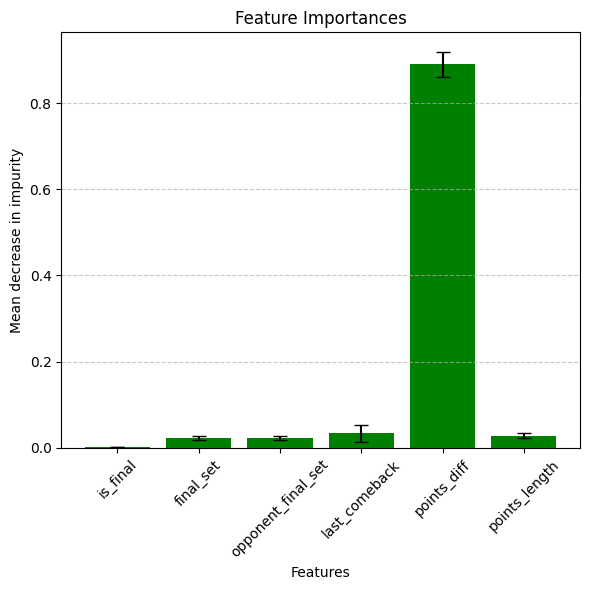

In [ ]:
# Grafico con barre e barre d'errore      IN UN DATASET CON CASI COME 9-6 è NORMALE CHE POINT_DIFF ABBIA QUESTO VALORE COSì ALTO
# VALORE DIFFERENTE AVREBBE SE CONSIDERASSIMO SOLO LE SITUAZIONI DI PAREGGIO IN CUI UN PO' TUTTO NON DA' VALORE
plt.figure(figsize=(6, 6))
plt.bar(feature_names, mean_importances, yerr=std_importances, color="green", alpha=1, capsize=5)
plt.title("Feature Importances")
plt.ylabel("Mean decrease in impurity")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Generazioni casi di test per i modelli

In [ ]:
def predict_probabilities(log_reg_model, test_sequences):

#Modelli attuali:  sgd_svm, calibrated_svm, xgboost, log_reg, rf(rf è il peggiore ma perchè è giusto per vedere l'importanza delle feature)
    probabilita = log_reg.predict_proba(test_sequences)
    return probabilita[:, 1]  # Restituisce le probabilità per la classe 1


# Dati di test (esempio)
X = [
    [0, 0, 0, -1, 0, 10],  # 5-5  punto a punto
    [0, 0, 0,  1, 0, 10],  # 5-5  punto a punto
    [0, 0, 0,  5, 0, 10],  # 5-5  rimonta mia
    [0, 0, 0, -5, 0, 10],  # 5-5  rimonta sua
    [0, 0, 0, -1, 2, 10],  # 6-4  punto a punto
    [0, 0, 0,  1, 2, 10],  # 6-4  punto a punto
    [0, 0, 0,  6, 2, 10],  # 6-4  rimonta mia
    [0, 0, 0, -4, 2, 10],  # 6-4  rimonta sua
    [0, 0, 0, -1, -2, 10],  # 4-6  punto a punto
    [0, 0, 0,  1, -2, 10],  # 4-6  punto a punto
    [0, 0, 0,  4, -2, 10],  # 4-6  rimonta mia
    [0, 0, 0, -6, -2, 10],  # 4-6  rimonta sua
    [0, 0, 0, -1, 3, 13],  # 8-5  punto a punto
    [0, 0, 0,  1, 3, 13],  # 8-5  punto a punto
    [0, 0, 0,  8, 3, 13],  # 8-5  rimonta mia
    [0, 0, 0, -5, 3, 13],  # 8-5  rimonta sua
]

X_scaled = scaler.transform(X)
probabilita = predict_probabilities(log_reg, X_scaled)

print("Predictions with input features:\n")
for i, (prob, features) in enumerate(zip(probabilita, X)):
    print(f"Instance {i+1}:")
    print(f"  Input to Model: {features}")
    print(f"  Predicted Probability: {prob:.4f}")
    print("-" * 80)

Predictions with input features:

Instance 1:
  Input to Model: [0, 0, 0, -1, 0, 10]
  Predicted Probability: 0.7495
--------------------------------------------------------------------------------
Instance 2:
  Input to Model: [0, 0, 0, 1, 0, 10]
  Predicted Probability: 0.7498
--------------------------------------------------------------------------------
Instance 3:
  Input to Model: [0, 0, 0, 5, 0, 10]
  Predicted Probability: 0.7504
--------------------------------------------------------------------------------
Instance 4:
  Input to Model: [0, 0, 0, -5, 0, 10]
  Predicted Probability: 0.7488
--------------------------------------------------------------------------------
Instance 5:
  Input to Model: [0, 0, 0, -1, 2, 10]
  Predicted Probability: 0.7495
--------------------------------------------------------------------------------
Instance 6:
  Input to Model: [0, 0, 0, 1, 2, 10]
  Predicted Probability: 0.7498
------------------------------------------------------------------

In [ ]:
'''
VEDERE LE PRESTAZIONI DEI MODELLI SUL TEST SET
ED EFFETTUARE ALTRE VALUTAZIONI PER CAPIRE CHI
FORNISCE PERCENTUALI PIU' VICINE A 1 QUANDO E' VERAMENTE 1 LA PREDIZIONE
E CHI FORNISCE PERCENTUALI PIU' VICINE A 0 QUANDO E' VERAMENTE 0 LA PREDIZIONE

INFINE FARE QUELLA VALUTAZIONI DI TUTTE LE TIPOLOGIE DI 6-4 PER VEDERE QUALE VALUTA MEGLIO
E SE SI TROVA ANCHE CON LE ALTRE TIPOLOGIE DI PUNTEGGIO
'''

### LSTM

 **LSTM** (Long Short-Term Memory), un tipo di rete neurale ricorrente è il modello che abbiamo deciso di utilizzare per effettuare previsioni sulle vittorie del set o meno.
 - LSTM può imparare come i punteggi cambiano in **base alle azioni precedenti**, ovvero, consentono di prevedere il risultato finale della partita basato **sull'andamento dei punteggi** (rimonta o stallo) durante il set.
 - Le variabili "is_final", "final_set", "opponent_final_set", permettono di integrare queste variabili temporali in modo che il modello non solo predica un punteggio finale, ma può anche tener conto di eventi come **"l'ultimo set"** o **"l'avversario in difficoltà"**.

 E' possibile migliorare questo modello per facilitarlo successivamente

In [ ]:
# Creazione del set di training

# Carica i dati dal dataset (presumibilmente già caricati come training_set)
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)
global_features = np.array(dataset[['is_final', 'final_set', 'opponent_final_set']])

# Converti ogni stringa in una lista di interi
player_points_converted = [eval(seq) if isinstance(seq, str) else seq for seq in player_points]

# Padding delle sequenze
max_sequence_length = 18  # Impostato come precedentemente
player_points_padded = pad_sequences(player_points_converted , maxlen=max_sequence_length, padding='post', truncating='post', value=-1)


X_train_seq = player_points_padded
X_train_global = global_features
Y_train = set_result

In [ ]:
'''
# Creazione del set di validazione

# Carica i dati dal dataset (presumibilmente già caricati come training_set)
player_points_val = np.array(test_set['player_points'].values)
set_result_val = np.array(test_set['set_result'].values)
global_features_val = np.array(test_set[['is_final', 'final_set', 'opponent_final_set']])

# Converti ogni stringa in una lista di interi
player_points_converted_val = [eval(seq) if isinstance(seq, str) else seq for seq in player_points_val]

player_points_padded_val = pad_sequences(player_points_converted_val , maxlen=max_sequence_length, padding='post', truncating='post', value=-1)


X_val_seq = player_points_padded_val
X_val_global = global_features_val
Y_val = set_result_val

'''

In [ ]:
'''
Testare il modello LSTM e vedere se è possibile migliorare gli iperparametri
'''
# Preparazione dei dati per l'input del modello

# Input per sequenze
sequence_input = Input(shape=(max_sequence_length,), name='sequence_input')

# Embedding con 3 possibili valori di input (es. 0, 1, -1) e vettori di dimensione 32.
x = Embedding(input_dim=3, output_dim=16)(sequence_input)

# Primo strato LSTM con 64 unità, che restituisce l'intera sequenza.
x = LSTM(64, return_sequences=True)(x)

# Secondo strato LSTM con 32 unità, che restituisce solo l'ultimo stato.
x = LSTM(32, return_sequences=False)(x)

# Input per feature globali
global_input = Input(shape=(3,), name='global_input')
global_dense = Dense(16, activation='relu')(global_input)

# Combina i due input
combined = concatenate([x, global_dense])

# Aggiungi Dropout per ridurre l'overfitting
x = Dropout(0.3)(combined)

# Strato denso con 32 unità per la combinazione.
x = Dense(32, activation='relu')(x)

# Output del modello con attivazione sigmoide per classificazione binaria
output = Dense(1, activation='sigmoid')(x)

# Costruisci il modello
lstm_model = Model(inputs=[sequence_input, global_input], outputs=output)

# Compila il modello
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Allenamento del modello LSTM(Provare anche con 20 epoche)
history_lstm = lstm_model.fit([X_train_seq, X_train_global], Y_train, epochs=5, batch_size=128)

Epoch 1/5
7646/7646 ━━━━━━━━━━━━━━━━━━━━ 352s 45ms/step - accuracy: 0.6998 - loss: 0.5790
Epoch 2/5
7032/7646 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.7083 - loss: 0.5695

In [ ]:
lstm_model.save('LSTM2.keras')

In [ ]:
# TESTING DEL MODELLO LSTM

# Esempi delle sequenze di test
test_examples = [
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0],  # Esempio 1
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],  # Esempio 2
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Esempio 3
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],  # Esempio 4
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # Esempio 5
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Esempio 6
    [1, 0, 1, 1, 0, 1, 0, 1, 1, 0],  # Esempio 7
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # Esempio 8
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],  # Esempio 9
]

# Esempio di global features per ogni esempio. (Imposta le tue feature globali reali)
global_features_example = [
    [1, 0, 0],  # Feature globali per esempio 1
    [1, 1, 1],  # Feature globali per esempio 2
    [0, 1, 0],  # Feature globali per esempio 3
    [1, 0, 0],  # Feature globali per esempio 4
    [1, 1, 1],  # Feature globali per esempio 5
    [0, 0, 0],  # Feature globali per esempio 6
    [1, 1, 1],  # Feature globali per esempio 7
    [0, 1, 0],  # Feature globali per esempio 8
    [1, 0, 1],  # Feature globali per esempio 9
]

# Padding delle sequenze di test
X_new = pad_sequences(test_examples, maxlen=18, padding='post', truncating='post', value=-1)

# Creare un array numpy per le global features (lo stesso numero di righe di X_new)
X_new_global = np.array(global_features_example)

# Prevedi le probabilità usando il modello
y_pred_prob_new = lstm_model.predict([X_new, X_new_global])

# Convertili in etichette binarie
y_pred_new = (y_pred_prob_new > 0.5).astype(int)

# Stampa le previsioni per ciascun esempio
for i, example in enumerate(test_examples):
    print(f"Esempio {i+1}: {example}")
    print(f"Probabilità previste: {y_pred_prob_new[i][0]:.4f}")
    print(f"Predizione (classe): {y_pred_new[i][0]}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
Esempio 1: [1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Probabilità previste: 0.5089
Predizione (classe): 1
--------------------------------------------------
Esempio 2: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Probabilità previste: 0.5518
Predizione (classe): 1
--------------------------------------------------
Esempio 3: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Probabilità previste: 0.5871
Predizione (classe): 1
--------------------------------------------------
Esempio 4: [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]
Probabilità previste: 0.6354
Predizione (classe): 1
--------------------------------------------------
Esempio 5: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Probabilità previste: 0.6650
Predizione (classe): 1
--------------------------------------------------
Esempio 6: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Probabilità previste: 0.6116
Predizione (classe): 1
--------------------------------------------------
Esempio 7: [1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
Probabilità previste: 0.7328
Predizione 

In [ ]:
'''
# Valutazione del modello LSTM
loss_lstm, accuracy_lstm = lstm_model.evaluate([X_test_seq, X_test_global], Y_test, verbose=0)
Y_pred_lstm = lstm_model.predict([X_test_seq, X_test_global])

# Stampa dei risultati
print(f"LSTM - Test Loss: {loss_lstm:.4f}")
print(f"LSTM - Test Accuracy: {accuracy_lstm:.4f}")
'''

In [ ]:
'''# Verifichiamo che 'player_points' sia una lista di interi
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)  # Target binari

X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(player_points, set_result, test_size=0.2, random_state=42, stratify=set_result)

# Effettuiamo il padding per le sequenze di training e test
X_train = pad_sequences(X_train_raw, maxlen=18, padding='post', truncating='post', value=-1)
X_test = pad_sequences(X_test_raw, maxlen=18, padding='post', truncating='post', value=-1)

# Reshape del target
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

model = Sequential([
    Embedding(input_dim=3, output_dim=32),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dropout(0.3),  # Probabilità di disattivare un nodo
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Allenamento del modello
history = model.fit(X_train, Y_train, epochs=5, batch_size=64)'''

Epoch 1/5
6444/6444 ━━━━━━━━━━━━━━━━━━━━ 202s 30ms/step - accuracy: 0.7382 - loss: 0.5319
Epoch 2/5
6444/6444 ━━━━━━━━━━━━━━━━━━━━ 188s 29ms/step - accuracy: 0.7467 - loss: 0.5171
Epoch 3/5
6444/6444 ━━━━━━━━━━━━━━━━━━━━ 227s 33ms/step - accuracy: 0.7448 - loss: 0.5179
Epoch 4/5
6444/6444 ━━━━━━━━━━━━━━━━━━━━ 228s 28ms/step - accuracy: 0.7461 - loss: 0.5154
Epoch 5/5
6444/6444 ━━━━━━━━━━━━━━━━━━━━ 177s 28ms/step - accuracy: 0.7474 - loss: 0.5135


In [ ]:
'''
MIGLIORARE I PARAMETRI DELL' LSTM, come qui


# Assicurati che 'player_points' sia una lista di interi
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)  # Target binari

X_train, X_val, Y_train, Y_val = train_test_split(player_points, set_result, test_size=0.2, random_state=42)
X_train = pad_sequences(X_train, maxlen=19, padding='post', truncating='post', value=-1)
X_val = pad_sequences(X_val, maxlen=19, padding='post', truncating='post', value=-1)

# Reshape del target
Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)

model = Sequential([
    Embedding(input_dim=2, output_dim=64),  # Embedding layer (2 valori, 64 neuroni)
    LSTM(128, return_sequences=False),  # LSTM con 128 neuroni
    Dropout(0.5),  # Aggiungi Dropout per evitare overfitting
    Dense(64, activation='relu'),  # Aggiungi un layer Dense intermedio
    Dense(1, activation='sigmoid')  # Output layer per la classificazione binaria
])

# Compilazione del modello
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_val, Y_val), callbacks=[early_stopping])
'''

In [ ]:
'''
test_examples = [
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0],  # Esempio 1
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],  # Esempio 2
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Esempio 3
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],  # Esempio 1
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # Esempio 2
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Esempio 3
    [1, 0, 1, 1, 0, 1, 0, 1, 1, 0],  # Esempio 1
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # Esempio 2
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],  # Esempio 3
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [0, 1, 0, 0, 1, 0, 1, 0, 0, 1],
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
]

# Effettua il padding delle sequenze di input
X_new = pad_sequences(test_examples, maxlen=18, padding='post', truncating='post', value=-1)

# Prevedi le probabilità usando il modello
y_pred_prob_new = model.predict(X_new)

# Convertili in etichette binarie
y_pred_new = (y_pred_prob_new > 0.5).astype(int)

# Stampa le previsioni per ciascun esempio
for i, example in enumerate(test_examples):
    print(f"Esempio {i+1}: {example}")
    print(f"Probabilità previste: {y_pred_prob_new[i][0]:.4f}")
    print(f"Predizione (classe): {y_pred_new[i][0]}")
    print("-" * 50)
'''

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
Esempio 1: [1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Probabilità previste: 0.5167
Predizione (classe): 1
--------------------------------------------------
Esempio 2: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Probabilità previste: 0.5373
Predizione (classe): 1
--------------------------------------------------
Esempio 3: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Probabilità previste: 0.4895
Predizione (classe): 0
--------------------------------------------------
Esempio 4: [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]
Probabilità previste: 0.6724
Predizione (classe): 1
--------------------------------------------------
Esempio 5: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Probabilità previste: 0.6920
Predizione (classe): 1
--------------------------------------------------
Esempio 6: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Probabilità previste: 0.6414
Predizione (classe): 1
--------------------------------------------------
Esempio 7: [1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
Probabilità previste: 0.7835
Predizione 

### Funzione matematica

In [ ]:
from math import comb

def prob(p, x, y):
    # Somma della prima parte
    sum_part1 = 0
    for i in range(0, 10 - y):
        sum_part1 += p**(11 - x) * comb(10 + i - x, i) * (1 - p)**i

    # Seconda parte della formula
    part2 = p**(10 - x) * comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)
    part2 *= (p**2) / (1 - 2 * p * (1 - p))

    # Somma totale
    total = sum_part1 + part2
    return total

# Probabilità di vincere un punto
p = 0.5

# Lista per raccogliere i risultati
results = []

# Calcoliamo la probabilità per tutte le combinazioni di x e y con x <= 10 e y <= 10
for x in range(0, 11):  # x va da 0 a 10
    for y in range(0, 11):  # y va da 0 a 10
        if x + y >= 7:  # Condizione che x + y deve essere maggiore o uguale a 7
            result = prob(p, x, y)
            if 0.1 < result < 0.9:  # La probabilità deve essere compresa tra 0.1 e 0.9
                results.append((x, y, result))

# Ordinare i risultati in base alla probabilità
results.sort(key=lambda x: x[2])  # Ordinamento in base al terzo elemento (probabilità)

# Stampare i risultati ordinati
for x, y, result in results:
    print(f"Probabilità per x={x}, y={y}: {result}")


Probabilità per x=6, y=9: 0.109375
Probabilità per x=3, y=7: 0.11328125
Probabilità per x=8, y=10: 0.125
Probabilità per x=2, y=6: 0.1334228515625
Probabilità per x=5, y=8: 0.14453125
Probabilità per x=4, y=7: 0.171875
Probabilità per x=7, y=9: 0.1875
Probabilità per x=3, y=6: 0.19384765625
Probabilità per x=2, y=5: 0.21197509765625
Probabilità per x=6, y=8: 0.2265625
Probabilità per x=9, y=10: 0.25
Probabilità per x=5, y=7: 0.25390625
Probabilità per x=4, y=6: 0.2744140625
Probabilità per x=3, y=5: 0.29052734375
Probabilità per x=8, y=9: 0.3125
Probabilità per x=7, y=8: 0.34375
Probabilità per x=6, y=7: 0.36328125
Probabilità per x=5, y=6: 0.376953125
Probabilità per x=4, y=5: 0.38720703125
Probabilità per x=3, y=4: 0.395263671875
Probabilità per x=4, y=4: 0.5
Probabilità per x=5, y=5: 0.5
Probabilità per x=6, y=6: 0.5
Probabilità per x=7, y=7: 0.5
Probabilità per x=8, y=8: 0.5
Probabilità per x=9, y=9: 0.5
Probabilità per x=10, y=10: 0.5
Probabilità per x=4, y=3: 0.604736328125
Proba

In [ ]:
#Funzione che calcola matematicamente la probabilità di vittoria del set

from math import comb

def prob(p, x, y):
    # Somma della prima parte
    sum_part1 = 0
    for i in range(0, 10 - y):
        sum_part1 += p**(11 - x) * math.comb(10 + i - x, i) * (1 - p)**i

    # Seconda parte della formula
    part2 = p**(10 - x) * math.comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)
    part2 *= (p**2) / (1 - 2 * p * (1 - p))

    # Somma totale
    total = sum_part1 + part2
    return total

# Esempio di uso
p = 0.5  # Probabilità di vincere un punto
x = 8    # Punti già vinti dal giocatore
y = 8    # Punti già vinti dall'avversario

result = prob(p, x, y)
print("Probabilità:", result)

Probabilità: 0.5


In [ ]:
#Probabilità di arrivare 10-10

def prob(p, x, y):

    total = p**(10 - x) * math.comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)

    return total

# Esempio di uso
p = 0.5  # Probabilità di vincere un punto
x = 6    # Punti già vinti dal giocatore
y = 6    # Punti già vinti dall'avversario

result = prob(p, x, y)
print("Probabilità:", result)

Probabilità: 0.2734375


### Performance Analysis

In [ ]:
# ANALISI DELLA CORRELAZIONE LINEARE DELLE FEATURE
dataset.drop('player_points', axis=1, inplace=True)

corr = dataset.corr()
plt.figure(figsize=(10, 8))  # Aumenta le dimensioni del grafico
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10}, cbar=True)

# Ruotare le etichette delle colonne per evitare sovrapposizioni
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Mostrare il grafico
plt.tight_layout()  # Regola il layout per evitare sovrapposizioni
plt.show()

#Notiamo che i valori calcoli hanno una relazione lineare

In [ ]:
#ANALISI DELLA PROGRESSIONE DI APPRENDIMENTO del LOGISTIC REGRESSION


X_train_full, X_test, y_train_full, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Lista di dimensioni del training set
training_sizes = np.linspace(10, 400, 10, dtype=int)

# Per salvare gli F1-score
f1_scores = []

# Modello
model = LogisticRegression(max_iter=1000, random_state=42)

# Loop per addestrare il modello su set di training di dimensioni crescenti
for size in training_sizes:
    # Campioni di training ridotti
    X_train_subset = X_train_full[:size]
    y_train_subset = y_train_full[:size]

    # Addestramento del modello
    model.fit(X_train_subset, y_train_subset)

    # Predizione sul set di test
    y_pred = model.predict(X_test)

    # Calcola l'F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)


# Grafico del cambiamento dell'F1-score
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, f1_scores, marker='o', linestyle='-', color='b', label='F1-score')

# Aggiungi i valori veri sull'asse X
plt.xticks(training_sizes, labels=[str(x) for x in training_sizes], rotation=45)

plt.xlabel('Numero di campioni di training')
plt.ylabel('F1-score (weighted)')
plt.title('Cambiamento dell\'F1-score rispetto ai campioni di training')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# ANALISI DELLE PRESTAZIONI IN BASE ALLA LUNGHEZZA DELLA SEQUENZA - LSTM

# Calcola le lunghezze originali delle sequenze
performance_by_length = {}

# Troviamo gli indici delle sequenze che hanno una lunghezza pari a quella corrente.
sequence_lengths = [len(seq) for seq in X_test_raw]

# Creiamo gruppi basati sulle lunghezze
for length in range(1, 21):  # Lunghezze da 1 a 20
    indices = [idx for idx, seq_length in enumerate(sequence_lengths) if seq_length == length]

    if indices:  # Evita gruppi vuoti
        X_subset = X_test[indices]
        Y_subset = Y_test[indices]
        Y_pred_subset = model.predict(X_subset)

        # Convertiamo le probabilità in valori binari (0 o 1) utilizzando una soglia di 0.5.
        Y_pred_binary_subset = (Y_pred_subset > 0.5).astype(int)

        # Calcoliamo l'accuratezza confrontando i target veri (Y_subset) con le predizioni binarie.
        accuracy = accuracy_score(Y_subset, Y_pred_binary_subset)

        # Salviamo l'accuratezza nel dizionario associandola alla lunghezza corrente.
        performance_by_length[f"{length}"] = accuracy


'''
oppure per il modello con tutte le feature

# Analisi delle prestazioni per lunghezza delle sequenze
performance_by_length = {}
sequence_lengths = [len(seq) for seq in X_test_seq]

# Itera per lunghezze di sequenza da 1 a 20
for length in range(1, 21):  # Lunghezze da 1 a 20
    indices = [idx for idx, seq_length in enumerate(sequence_lengths) if seq_length == length]

    if indices:  # Procedi solo se ci sono sequenze con quella lunghezza
        X_subset = np.array([X_test_seq[idx] for idx in indices])
        Y_subset = np.array([Y_test[idx] for idx in indices])
        X_global_subset = np.array([X_test_global[idx] for idx in indices])

        # Assicurati che le sequenze abbiano la lunghezza corretta (es. padding/truncating)
        X_subset_padded = pad_sequences(X_subset, maxlen=19, padding='post', truncating='post', value=-1)

        # Predici i risultati
        Y_pred_subset = lstm_model.predict([X_subset_padded, X_global_subset])
        Y_pred_binary_subset = (Y_pred_subset > 0.5).astype(int)

        # Calcola l'accuratezza
        accuracy = accuracy_score(Y_subset, Y_pred_binary_subset)
        performance_by_length[f"{length}"] = accuracy
'''

plt.figure(figsize=(8, 6))
# Aggiusta per visualizzare le lunghezze come numeri e l'accuratezza associata
lengths = list(range(1, 21))  # Lunghezze da 1 a 19

# Estraiamo le accuratezze corrispondenti alle lunghezze e se la lunghezza non è presente assegniamo 0
accuracies = [performance_by_length.get(str(length), 0) for length in lengths]

plt.bar(lengths, accuracies, color='skyblue')
plt.xlabel('Lunghezza delle sequenze')
plt.ylabel('Accuratezza')
plt.title('Prestazioni del modello in base alla lunghezza delle sequenze')
plt.xticks(lengths)  # Mostra tutte le lunghezze sull'asse x
plt.show()

In [ ]:
# Calcolo della curva ROC LSTM
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)

# Grafico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'LSTM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Vero Positivo Rate')
plt.title('Curva ROC per LSTM')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Grafico diminuzione della loss durante le poche LSTM
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Curva di apprendimento per LSTM')
plt.legend()
plt.show()

# Grafico miglioramento dell'accuratezza durante le epoche LSTM
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuratezza durante il training per LSTM')
plt.legend()
plt.show()

In [ ]:
# Calcolo della matrice di confusione
cm = confusion_matrix(Y_test, Y_pred_binary)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'])
plt.title('Matrice di Confusione per LSTM')
plt.xlabel('Predizioni')
plt.ylabel('Verità Effettive')
plt.show()

In [ ]:
#LOGISTIC REGRESSION VS CROSSVALIDATED LOGISTIC REGRESSION


# Visualizzazione delle performance di Accuratezza
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar(['K-Fold', 'Test-Split'], [mean_accuracy_kf, accuracy_ts], color=['blue', 'green'])
plt.title('Confronto Accuratezza')
plt.ylabel('Accuratezza')

# Visualizzazione delle performance di AUC
plt.subplot(1, 3, 2)
plt.bar(['K-Fold', 'Test-Split'], [mean_roc_auc_kf, roc_auc_ts], color=['blue', 'green'])
plt.title('Confronto AUC')
plt.ylabel('AUC')

# Visualizzazione delle performance di Log Loss
plt.subplot(1, 3, 3)
plt.bar(['K-Fold', 'Test-Split'], [mean_log_loss_kf, log_loss_ts], color=['blue', 'green'])
plt.title('Confronto Log Loss')
plt.ylabel('Log Loss')

plt.tight_layout()
plt.show()

# ROC Curve per il confronto visivo
fpr_kf, tpr_kf, _ = roc_curve(Y_test, logreg_model_kf.predict_proba(X_test)[:, 1])
fpr_ts, tpr_ts, _ = roc_curve(Y_test, logreg_model_ts.predict_proba(X_test)[:, 1])

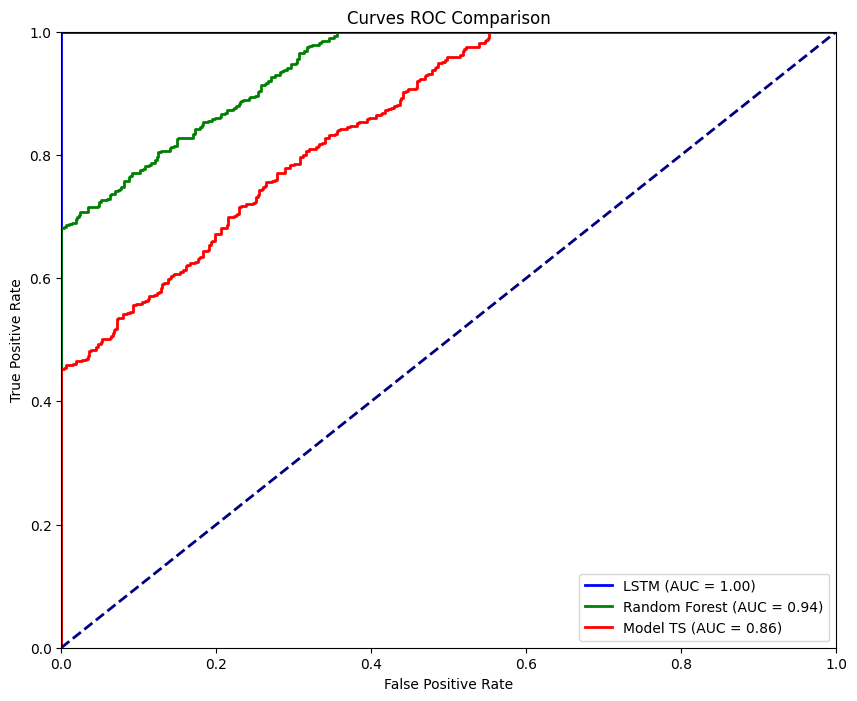

In [ ]:
# CONFRONTO DI ROC CURVE DI MODELLI DIFFERENTI

# Numero di campioni
n_samples = 1000

# Genera etichette vere (0 o 1) casuali
y_true = np.random.randint(0, 2, size=n_samples)


# MODIFICARE QUI, DOBBIAMO METTERE LE PRESTAZIONI VERE
# Genera probabilità predette per i tre modelli con una maggiore separazione tra le classi
# Per i modelli, facciamo in modo che le probabilità per la classe positiva siano abbastanza alte
y_pred_lstm = np.random.rand(n_samples) * 0.5 + (y_true == 1) * 0.5  # maggiore probabilità per classi positive
y_pred_rf = np.random.rand(n_samples) * 0.6 + (y_true == 1) * 0.4  # un po' di separazione maggiore
y_pred_ts = np.random.rand(n_samples) * 0.7 + (y_true == 1) * 0.3  # separazione simile

# Calcola le curve ROC per ogni modello
fpr_lstm, tpr_lstm, _ = roc_curve(y_true, y_pred_lstm)
fpr_rf, tpr_rf, _ = roc_curve(y_true, y_pred_rf)
fpr_ts, tpr_ts, _ = roc_curve(y_true, y_pred_ts)

# Calcola l'AUC per ogni modello
roc_auc_lstm = roc_auc_score(y_true, y_pred_lstm)
roc_auc_rf = roc_auc_score(y_true, y_pred_rf)
roc_auc_ts = roc_auc_score(y_true, y_pred_ts)

# Creazione del grafico
plt.figure(figsize=(10, 8))

# Aggiungi tutte le curve ROC al grafico
plt.plot(fpr_lstm, tpr_lstm, color='blue', lw=2, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_ts, tpr_ts, color='red', lw=2, label=f'Model TS (AUC = {roc_auc_ts:.2f})')

# Linea diagonale (linea di casualità)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Etichette e titolo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curves ROC Comparison')
plt.legend(loc='lower right')

# Mostra il grafico
plt.show()

In [ ]:
# STATISTICHE PER RANDOM FOREST

# Calcolo della curva ROC

Y_pred = rf_model.predict(X_test)

fpr_rf, tpr_rf, _ = roc_curve(Y_test, Y_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Grafico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Vero Positivo Rate')
plt.title('Curva ROC per RF')
plt.legend(loc='lower right')
plt.show()

# Convertiamo le predizioni in etichette binarie
Y_pred_binary = (Y_pred > 0.5).astype(int)

# Calcolo della matrice di confusione
cm = confusion_matrix(Y_test, Y_pred_binary)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'])
plt.title('Matrice di Confusione per RF')
plt.xlabel('Predizioni')
plt.ylabel('Verità Effettive')
plt.show()


In [ ]:
# ?

plt.figure(figsize=(8, 6))
plt.plot(fpr_kf, tpr_kf, color='blue', label=f'K-Fold (AUC = {mean_roc_auc_kf:.2f})')
plt.plot(fpr_ts, tpr_ts, color='green', label=f'Test-Split (AUC = {roc_auc_ts:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve: K-Fold vs Test-Split')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()